In [1]:
%matplotlib inline
import math
import scipy
from scipy.stats import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines


colorDic = {"blue" : "#6599FF", "yellow" : "#FFAD33",  "purple": "#683b96", "green" : "#198D6D", "red" : "#FF523F"}
colors = list(colorDic.values())

raycasts = ["IFRC", "FRC","HRC", "EFRC"]
OUTPUT_PATH = "./out/"

In [2]:
'''
Find intersection with infinite cylinder with center in the origin
to do that, translate the ray origin so that the center of the bottom base
is at the origin, then calculate intersection with the canonical infinite cylinder
and check if the ray intersects the lateral surface of the cylinder within our
bases, if not check if it's intersecting the bases and if not, it's not intersecting
our actual cylinder
'''
def calcCylinderIntersectValue (centerBottomBase, radius, rayOrigin, rayDirection):
    # translate the ray origin
    # Point 
    p0 = np.array([rayOrigin[0]-centerBottomBase[0], rayOrigin[1]-centerBottomBase[1], rayOrigin[2]-centerBottomBase[2]])
    # coefficients for the intersection equation
    # got them mathematically intersecting the line equation with the cylinder equation
    a = rayDirection[0] * rayDirection[0] + rayDirection[2] * rayDirection[2]
    b = rayDirection[0]*p0[0] +rayDirection[2]*p0[2]
    c = p0[0]*p0[0]+p0[2]*p0[2]-radius*radius
    delta = b*b - a*c

    #use epsilon because of computation errors between doubles
    epsilon = 0.00000001

    # delta < 0 means no intersections
    if (delta < epsilon):
        return (False, np.inf, np.inf)

    # nearest intersection
    t1 = (-b - np.sqrt (delta))/a
    t2 = (-b + np.sqrt (delta))/a
    return (True, t1, t2)

def calcCylinderIntersect (centerBottomBase, radius, rayOrigin, rayDirection):
    b, t1, t2 = calcCylinderIntersectValue(centerBottomBase, radius, rayOrigin, rayDirection)
    if (b):
        i1, i2 = (rayOrigin + rayDirection* t1, rayOrigin + rayDirection* t2)
        d1 = np.sqrt(np.sum(np.square(rayDirection- i1)))
        d2 = np.sqrt(np.sum(np.square(rayDirection- i2)))
        if (d1 < d2):
            return i1
        else:
            return i2
    else:
        return np.inf
    
def rotate3DAroundOrigin(point, pitch, yaw):
    x = point[:,0]
    y = point[:,1]
    z = point[:,2]
    r = np.sqrt(x*x + y*y + z*z)
    phi = np.arctan2(x,z)+np.deg2rad(yaw)
    theta = np.arccos(y/r)+np.deg2rad(pitch)
    x = r * np.sin( theta ) * np.sin( phi )
    y = r * np.cos( theta )
    z = r * np.sin( theta ) * np.cos( phi )
    
    
    return np.array([x,y,z]).T

def getOrientaion(points):
    x = points[:,0]
    y = points[:,1]
    z = points[:,2]
    r = np.sqrt(x*x + y*y + z*z)
    phi = np.arctan2(x,z)
    theta = np.arccos(y/r)
    return np.array([np.rad2deg(theta), np.rad2deg(phi)]).T
    
    #yaw = np.arctan2(points[:,0], points[:,2])
    #pitch = np.arctan2(np.sqrt((points[:,0] * points[:,0]) + (points[:,1] * points[:,1])), points[:,2]);
    #return np.array([np.rad2deg(pitch), np.rad2deg(yaw)]).T

points = np.array([[1,1,0], [1,-1,0], [1,99,0], [1,-99,0],[1,1,1], [5, 5,5], [-5, -5,-5]])
getOrientaion(points)

array([[  45.        ,   90.        ],
       [ 135.        ,   90.        ],
       [   0.57872557,   90.        ],
       [ 179.42127443,   90.        ],
       [  54.73561032,   45.        ],
       [  54.73561032,   45.        ],
       [ 125.26438968, -135.        ]])

In [3]:
dfMatch = pd.read_pickle(OUTPUT_PATH + "data_v02.pkl")
dfPointer = dfMatch[dfMatch.IsPointer == True].copy(deep=True)
del dfMatch
len(dfPointer)

3360

In [4]:
i = 0
dfPointer["TargetId2"] = -1
for y in sorted(dfPointer.TargetProjectionY.unique()):
    for x in sorted(dfPointer.TargetProjectionX.unique()):
        dfPointer.loc[(dfPointer.TargetProjectionX == x) & (dfPointer.TargetProjectionY == y), "TargetId2"] = i
        i = i+1

In [5]:
for rc in raycasts:
    target = np.array(list(dfPointer["TargetPos"].apply(lambda x: list(x)).values))
    intersection = np.array(list(dfPointer["Intersection"+rc].apply(lambda x: list(x)).values))
    
    if(rc == "IFRC"):
        origin = np.array(list(dfPointer["FingertipPos"].apply(lambda x: list(x)).values))
    elif(rc == "FRC"):
        origin = np.array(list(dfPointer["RightLowerArmPos"].apply(lambda x: list(x)).values))
    else:
        origin = np.array(list(dfPointer["HMDPos"].apply(lambda x: list(x)).values))
    
    rotations = getOrientaion(target-origin)
    dfPointer["Target"+rc+"Pitch"] = rotations[:,0]
    dfPointer["Target"+rc+"Yaw"] = rotations[:,1]
    
    rotations = getOrientaion(intersection-origin)
    dfPointer[rc+"Pitch"] = rotations[:,0]
    dfPointer[rc+"Yaw"] = rotations[:,1]
    
    dfPointer[rc+"PitchError"] = dfPointer[rc+"Pitch"]-dfPointer["Target"+rc+"Pitch"]
    dfPointer.loc[dfPointer[rc+"PitchError"] > 180, rc+"PitchError"] = dfPointer[rc+"PitchError"]-360
    dfPointer.loc[dfPointer[rc+"PitchError"] < -180, rc+"PitchError"] = dfPointer[rc+"PitchError"]+360
    
    dfPointer[rc+"YawError"] = dfPointer[rc+"Yaw"]-dfPointer["Target"+rc+"Yaw"]
    dfPointer.loc[dfPointer[rc+"YawError"] > 180, rc+"YawError"] = dfPointer[rc+"YawError"]-360
    dfPointer.loc[dfPointer[rc+"YawError"] < -180, rc+"YawError"] = dfPointer[rc+"YawError"]+360

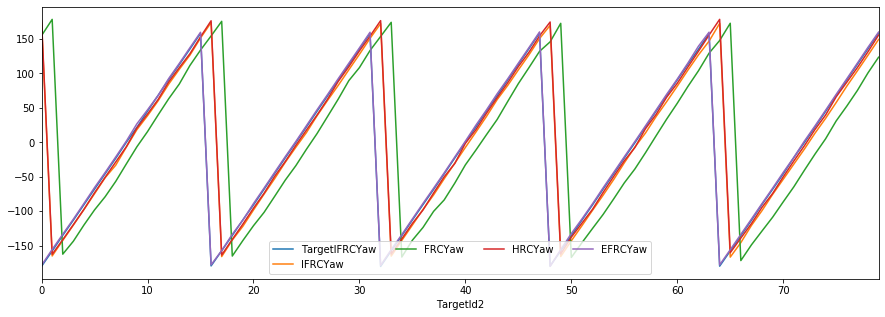

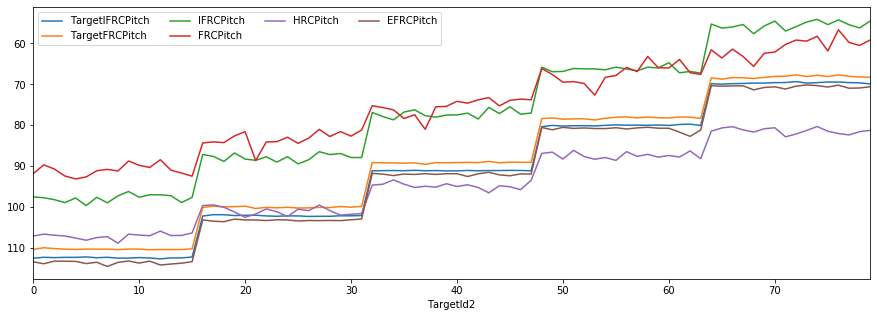

In [6]:
lst = ["TargetId2"]
dfError = dfPointer.groupby("TargetId2").mean().reset_index(drop=False)
for c in dfPointer.columns:
    if ("Yaw" in c) or ("Pitch" in c):
        lst.append(c)

for c in lst:
    for target in dfError.TargetId:
        x = dfPointer[dfPointer.TargetId == target][c].values
        dfError.loc[dfError.TargetId == target, c] = np.rad2deg(scipy.stats.circmean(np.deg2rad(x)))
    dfError.loc[dfError[c] > 180, c] = dfError[c]-360

dfError["HMDPos"] = dfPointer.groupby(dfPointer.TargetId).HMDPos.apply(lambda x: np.mean(np.array(list(x)), axis=0))
dfError["TargetPos"] = dfPointer.groupby(dfPointer.TargetId).TargetPos.apply(lambda x: np.mean(np.array(list(x)), axis=0))
dfError["FingertipPos"] = dfPointer.groupby(dfPointer.TargetId).FingertipPos.apply(lambda x: np.mean(np.array(list(x)), axis=0))
dfError["RightLowerArmPos"] = dfPointer.groupby(dfPointer.TargetId).RightLowerArmPos.apply(lambda x: np.mean(np.array(list(x)), axis=0))

df = dfError[["TargetId2", "TargetIFRCYaw", "IFRCYaw", "FRCYaw", "HRCYaw", "EFRCYaw"]]
df = df.sort_values("TargetId2").set_index("TargetId2")
fix,ax = plt.subplots(1,1,figsize=(15,5))
df.plot(ax=ax)
#dfError.groupby('TargetId').mean()["TargetAngle"].plot(ax=ax)
plt.legend(ncol=4)
df.describe()
plt.show()

df = dfError[["TargetId2", "TargetIFRCPitch", "TargetFRCPitch", "IFRCPitch", "FRCPitch", "HRCPitch", "EFRCPitch"]]
df = df.sort_values("TargetId2").set_index("TargetId2")
fix,ax = plt.subplots(1,1,figsize=(15,5))
df.plot(ax=ax)
plt.legend(ncol=4)
df.describe()
plt.gca().invert_yaxis()
plt.show()

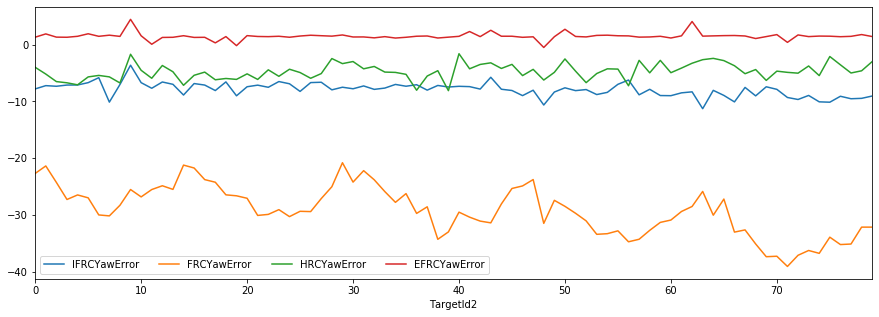

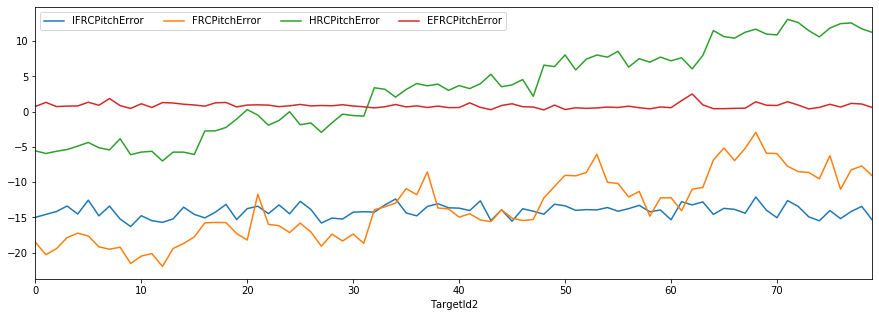

In [7]:
lst = ["TargetId2"]
for c in dfPointer.columns:
    if ("Yaw" in c) or ("Pitch" in c):
        lst.append(c)

for c in lst:
    for target in dfError.TargetId:
        x = dfPointer[dfPointer.TargetId == target][c].values
        dfError.loc[dfError.TargetId == target, c] = np.rad2deg(scipy.stats.circmean(np.deg2rad(x)))
    dfError.loc[dfError[c] > 180, c] = dfError[c]-360

df = dfError[["TargetId2", "IFRCYawError", "FRCYawError", "HRCYawError", "EFRCYawError"]]
df = df.sort_values("TargetId2").set_index("TargetId2")
fix,ax = plt.subplots(1,1,figsize=(15,5))
df.plot(ax=ax)
#dfError.groupby('TargetId').mean()["TargetAngle"].plot(ax=ax)
plt.legend(ncol=4)
df.describe()
plt.show()

df = dfError[["TargetId2", "IFRCPitchError", "FRCPitchError", "HRCPitchError", "EFRCPitchError"]]
df = df.sort_values("TargetId2").set_index("TargetId2")
fix,ax = plt.subplots(1,1,figsize=(15,5))
df.plot(ax=ax)
plt.legend(ncol=4)
df.describe()
plt.show()

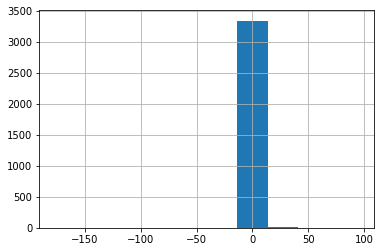

In [8]:
dfPointer[rc+"YawError"].hist()

In [9]:
for rc in sorted(raycasts):
    #point =  np.array(list(dfPointer["Target"+ rc].apply(lambda x: list(x)).values))
    if(rc == "IFRC"):
        origin = np.array(list(dfPointer["FingertipPos"].apply(lambda x: list(x)).values))
    elif(rc == "FRC"):
        origin = np.array(list(dfPointer["RightLowerArmPos"].apply(lambda x: list(x)).values))
    elif (rc=="EFRC"):
        origin = np.array(list(dfPointer["HMDPos"].apply(lambda x: list(x)).values))
    else:
        origin = np.array(list(dfPointer["HMDPos"].apply(lambda x: list(x)).values))
        
    point = np.array(list(dfPointer["Intersection"+ rc].apply(lambda x: list(x)).values))
    print(rc)
    intersect1 = rotate3DAroundOrigin(point-origin, dfPointer[rc+"PitchError"].values, dfPointer[rc+"YawError"].values)
    intersect2 = intersect1+origin
    
    
    centerBottomBase = np.array([0,1,0])
    intersectReal = np.zeros(intersect2.shape)
    for i in range(intersect2.shape[0]):
        intersectReal[i] = calcCylinderIntersect (centerBottomBase, 4.0, origin[i], intersect2[i]-origin[i])
    dfPointer["Intersection"+rc+"FromTarget"]  = list(intersectReal)


EFRC
FRC
HRC
IFRC


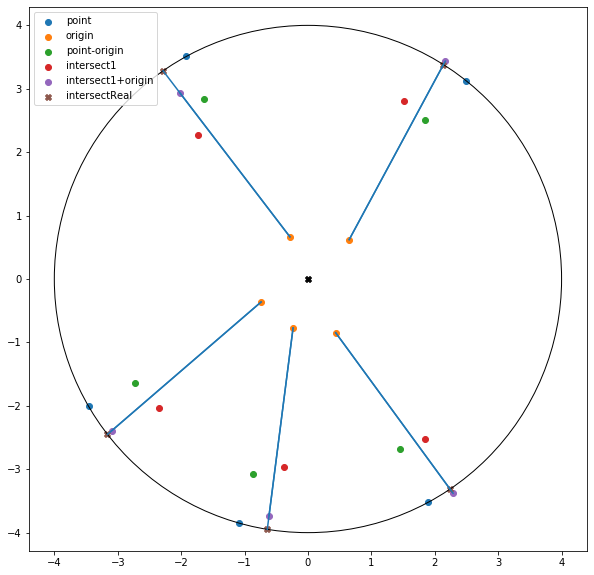

In [10]:
from matplotlib.patches import Circle
fig, ax = plt.subplots(figsize=(10,10))

plt.scatter(0,0, marker="X", color="k")
plt.scatter(point[:5,0],point[:5,2], label="point")
plt.scatter(origin[:5,0],origin[:5,2], label="origin")
plt.scatter((point-origin)[:5,0],(point-origin)[:5,2], label="point-origin")
plt.scatter(intersect1[:5,0],intersect1[:5,2], label="intersect1")
plt.scatter(intersect2[:5,0],intersect2[:5,2], label="intersect1+origin")
plt.scatter(intersectReal[:5,0],intersectReal[:5,2], marker="X", label="intersectReal")

for i in range(5):
    l = mlines.Line2D([intersect2[i,0],origin[i,0]], [intersect2[i,2],origin[i,2]])
    ax.add_line(l)
    
for i in range(5):
    l = mlines.Line2D([origin[i,0],intersectReal[i,0]], [origin[i,2],intersectReal[i,2]])
    ax.add_line(l)
    
circle = Circle((0, 0), 4.0, fill=False)
ax.add_patch(circle)
plt.axis('equal')
plt.legend()

In [11]:
(point -intersectReal).mean(axis=0).round(3)

array([ 0.002, -1.991, -0.002])

In [12]:
(point)[:,1].mean()

2.498554400136905

In [13]:
(origin)[:,1].mean()

1.6232258308630954

In [14]:
(point-origin)[:,1].mean()

0.8753285692738095

In [15]:
intersect1[:,1].mean()

1.6263469243586104

In [16]:
intersect2[:,1].mean()

3.2495727552217053

In [17]:
intersectReal[:,1].mean()

4.489573194460975

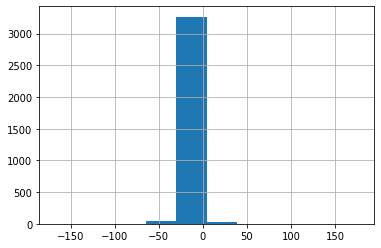

In [18]:
dfPointer[rc+"YawError"].hist()

(-4.486917500677183, 4.486658500677182, -4.533926360645327, 4.534073360645326)

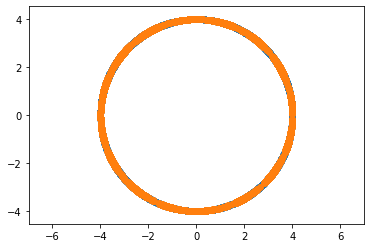

In [19]:
plt.scatter(np.array(list(dfPointer["Intersection"+rc+"FromTarget"].apply(lambda x: list(x)).values))[:,0], 
        np.array(list(dfPointer["Intersection"+rc+"FromTarget"].apply(lambda x: list(x)).values))[:,2])

plt.scatter(np.array(list(dfPointer["Intersection"+rc+""].apply(lambda x: list(x)).values))[:,0], 
        np.array(list(dfPointer["Intersection"+rc+""].apply(lambda x: list(x)).values))[:,2])
plt.axis('equal')

In [22]:
for rc in raycasts:
    dfPointer[rc+"Angle"] = dfPointer["Intersection"+ rc+"FromTarget"].apply(lambda x: math.degrees(math.atan2(x[0],x[2])))
    dfPointer[rc+"X"]  = (dfPointer[rc + "Angle"] / 180.0) * np.pi * 4.0
    dfPointer[rc+"Y"]  = dfPointer["Intersection"+ rc+"FromTarget"].apply(lambda x: x[1])
    dfPointer[rc+"XCorected"] = dfPointer[rc+"X"]
    
    dfPointer[rc+"XCorected"] = dfPointer[["TargetProjectionX", rc+"X"]].apply(lambda x:  x[rc+"X"] - 4*np.pi*2 if x[rc+"X"] - x.TargetProjectionX > 4*np.pi else x[rc+"X"] ,axis=1)
    
    dfPointer[rc+"DistanceError"] = np.sqrt(np.power(dfPointer.TargetProjectionX-dfPointer[rc+"XCorected"], 2) + 
                        np.power(dfPointer.TargetProjectionY-dfPointer[rc+"Y"], 2))

IFRC filtered: 0.51 %


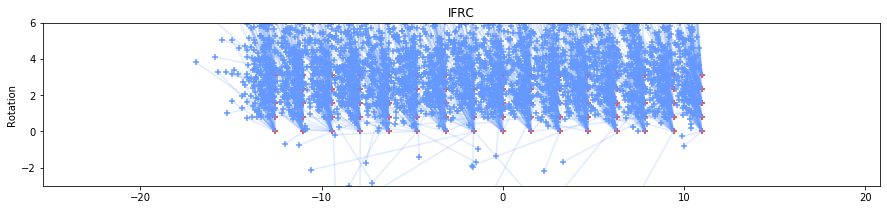

FRC filtered: 0.39 %


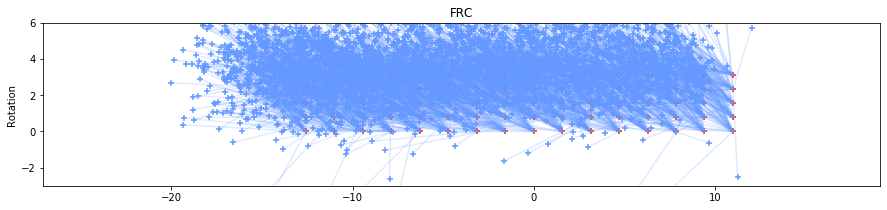

HRC filtered: 0.74 %


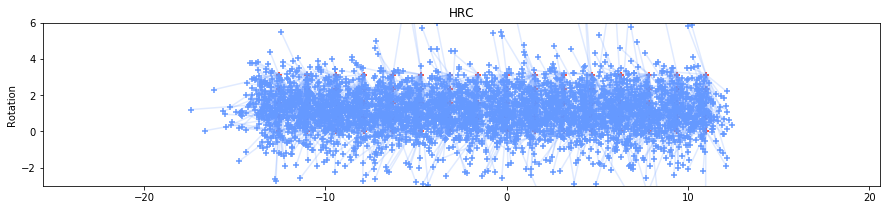

EFRC filtered: 0.03 %


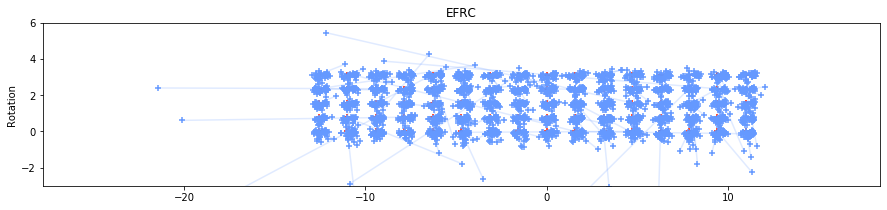

In [23]:
  
for rc in raycasts:
    plt.figure(figsize=(15,3))
    
    f = dfPointer[rc+"DistanceError"].describe()
    dfPointerFiltered = dfPointer[dfPointer[rc+"DistanceError"] < f["mean"] + 3 * f["std"]]
    
    print("%s filtered: %.2f %%" % (rc, (1-len(dfPointerFiltered)/len(dfPointer))*100))
    plt.title(rc)
    plt.scatter(dfPointerFiltered.TargetProjectionX, dfPointerFiltered.TargetProjectionY, marker="+", color=colorDic["red"], label="Target")
    plt.scatter(dfPointerFiltered[rc+"XCorected"], dfPointerFiltered[rc+"Y"], marker="+", color=colorDic["blue"])
    ax = plt.gca()
    for i, e in dfPointerFiltered.iterrows():
        l = mlines.Line2D([e.TargetProjectionX, e[rc+"XCorected"]], [e.TargetProjectionY, e[rc+"Y"]], color=colorDic["blue"], alpha=0.2)
        ax.add_line(l)
        
    lstTicks = []
    plt.axis('equal')
    plt.ylim(-3, 6)
    #for x in np.arange(-180,181,45):
    #    lstTicks.append(str(x)+"°")
    #plt.xticks((4*np.pi*2)/360 * np.arange(-180,181,45), lstTicks)

    plt.ylabel("Hight in m")
    plt.ylabel("Rotation")

   
    plt.show()

In [25]:
dfPointer.to_pickle(OUTPUT_PATH  + "data_v03_PointerOnly.pkl")